# Compare Experiment Runs

This notebook loads results from multiple experiment runs (each run is a folder under `results/`), merges their `master_results.csv` and per-class `class_report.json` (and optional `per_image_metrics.csv`), and produces comparative plots and simple statistical tests.

Usage: edit the `results_root` and `run_names` list in the parameters cell (Cell 3) and run the notebook cells in order.

In [1]:
# Standard imports
import os
import json
import warnings
from pathlib import Path
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Stats & metrics used by the plotting cells
import scipy.stats as sps
from sklearn.metrics import roc_auc_score

# Make seaborn prettier by default
sns.set(style='whitegrid', font_scale=1.05)
plt.rcParams['figure.dpi'] = 100


In [25]:
# ----------------- USER PARAMETERS (edit here) -----------------
# Base folder that contains run subfolders (usually './results')
results_root = Path('./results')
# List run folder names (these are the directory names under results_root).
# Resolution: explicit run list provided below
run_names = [
    'resnet18_256_color_profile_3',
    'resnet18_512_color_profile_3',
    'wide_resnet50_256_color_profile_3',
]

# If run_names is empty, try to autodiscover all folders under results_root
if len(run_names) == 0:
    run_names = [p.name for p in results_root.iterdir() if p.is_dir()]
print(f'Results root: {results_root.resolve()}')
print('Runs to compare:')
for r in run_names:
    print(' -', r)


Results root: /home/mikeszklarz/dev/lanl/PaDiM-Anomaly-Detection-Localization-master/results
Runs to compare:
 - resnet18_256_color_profile_3
 - resnet18_512_color_profile_3
 - wide_resnet50_256_color_profile_3


In [26]:
# Helper: load master_results.csv for a run (returns DataFrame or None)
def load_master(run_path: Path):
    path = run_path / 'master_results.csv'
    if not path.exists():
        warnings.warn(f'master_results.csv not found for run: {run_path}')
        return None
    try:
        df = pd.read_csv(path)
        df['run_name'] = run_path.name
        return df
    except Exception as e:
        warnings.warn(f'Failed to read {path}: {e}')
        return None
# Helper: load per-class class_report.json files for a run (returns DataFrame)
def load_class_reports(run_path: Path):
    rows = []
    # Look for subfolders containing class_report.json
    for class_sub in run_path.iterdir():
        if not class_sub.is_dir():
            continue
        cr = class_sub / 'class_report.json'
        if not cr.exists():
            continue
        try:
            with open(cr, 'r') as f:
                data = json.load(f)
            data['class_folder'] = class_sub.name
            data['run_name'] = run_path.name
            rows.append(data)
        except Exception as e:
            warnings.warn(f'Failed to load {cr}: {e}')
    if len(rows) == 0:
        return None
    return pd.json_normalize(rows)

In [27]:
# Load all runs into DataFrames
master_dfs = []
class_report_dfs = []

# Helper to shorten run names for plotting
def shorten_run_name(name: str) -> str:
    # Examples:
    # resnet18_256_color_profile_1 -> rsn18_256_cp1
    # resnet18_512_color_profile_1 -> rsn18_512_cp1
    # wide_resnet50_2_resize-256_crop-256 -> wrsn50_256
    # We'll capture known tokens (model, resolution, profile) and create compact labels.
    name = str(name)
    # detect model
    if 'resnet18' in name:
        model = 'rsn18'
    elif 'wide_resnet50' in name or 'wide_resnet50_2' in name:
        model = 'wrsn50'
    else:
        # fallback: take first 6 alphanumeric chars
        model = re.sub('[^0-9a-zA-Z]+', '', name)[:6]
    # detect resolution (common patterns: resize-256, _256_, crop-256, -256)
    res_match = re.search(r'(?:resize[_-]|crop[_-]|_)(\d{3,4})(?:\b|_)', name)
    if not res_match:
        # fallback: any standalone 3-4 digit number
        res_match = re.search(r'(\d{3,4})', name)
    resolution = res_match.group(1) if res_match else ''
    # detect color_profile or profile id
    m = re.search(r'color_profile[_-]?(\d+)', name)
    if not m:
        m = re.search(r'profile[_-]?(\d+)', name)
    profile = f'cp{m.group(1)}' if m else ''
    # build parts (model + resolution + profile when available)
    parts = [model]
    if resolution:
        parts.append(resolution)
    if profile:
        parts.append(profile)
    short = '_'.join(parts)
    return short

for rn in run_names:
    run_path = results_root / rn
    if not run_path.exists():
        warnings.warn(f'Run folder not found: {run_path} - skipping')
        continue
    mdf = load_master(run_path)
    if mdf is not None:
        print(shorten_run_name(rn))
        mdf['short_run'] = shorten_run_name(rn)
        mdf['run_name'] = rn
        master_dfs.append(mdf)
    crdf = load_class_reports(run_path)
    if crdf is not None:
        crdf['short_run'] = shorten_run_name(rn)
        crdf['run_name'] = rn
        class_report_dfs.append(crdf)
# Concatenate
master_all = pd.concat(master_dfs, ignore_index=True) if master_dfs else pd.DataFrame()
class_reports_all = pd.concat(class_report_dfs, ignore_index=True) if class_report_dfs else pd.DataFrame()
print('Loaded master results rows:', len(master_all))
print('Loaded class reports rows:', len(class_reports_all))

# Create mapping from original run_name to short label for plotting convenience
run_name_map = {r: shorten_run_name(r) for r in run_names}


rsn18_256_cp3
rsn18_512_cp3
wrsn50_256_cp3
Loaded master results rows: 3
Loaded class reports rows: 3


In [28]:
master_all

,class_name,roc_auc,optimal_threshold,precision,recall,f1_score,true_negatives,false_positives,false_negatives,true_positives,cohen_d,wasserstein,mannwhitney_p,roc_auc_ci_low,roc_auc_ci_high,run_name,short_run
0,color_profile_3,0.7561,0.2381,0.6042,0.7073,0.6517,55,19,12,29,0.6594,0.0899,0.000006,0.6642,0.8462,resnet18_256_color_profile_3,rsn18_256_cp3
1,color_profile_3,0.7657,0.3714,0.6047,0.6341,0.6190,57,17,15,26,0.9133,0.1302,0.000003,0.6711,0.8461,resnet18_512_color_profile_3,rsn18_512_cp3
2,color_profile_3,0.8431,0.3977,0.7174,0.8049,0.7586,61,13,8,33,1.0809,0.1537,0.000000,0.7695,0.9124,wide_resnet50_256_color_profile_3,wrsn50_256_cp3


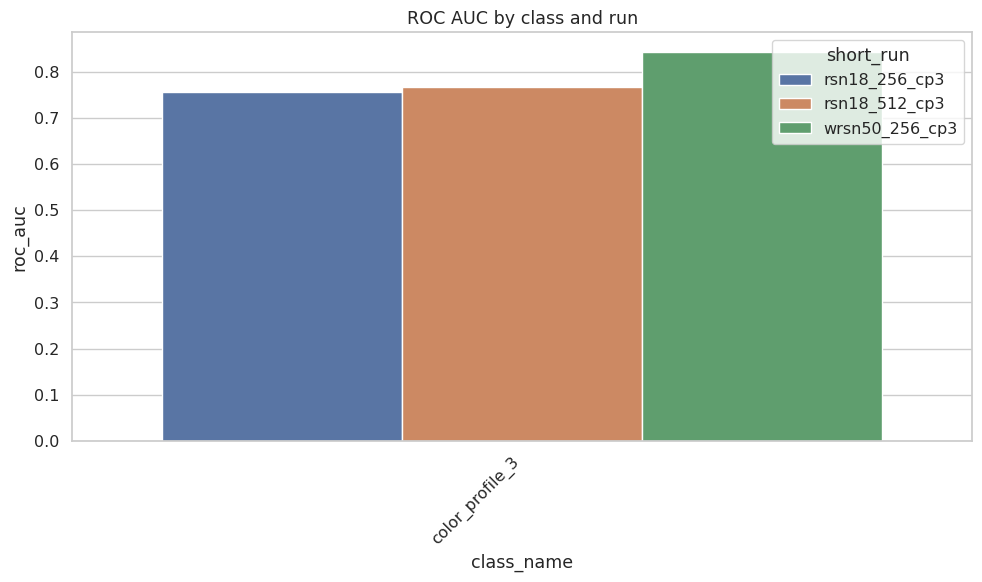

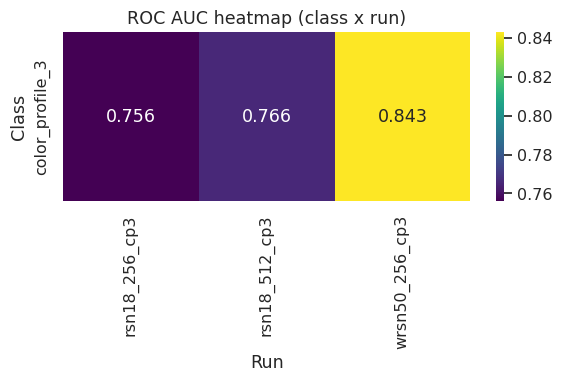

,short_run,roc_auc,precision,recall,f1_score
0,rsn18_256_cp3,0.7561,0.6042,0.7073,0.6517
1,rsn18_512_cp3,0.7657,0.6047,0.6341,0.6190
2,wrsn50_256_cp3,0.8431,0.7174,0.8049,0.7586


/tmp/ipykernel_226879/1998750668.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_xticklabels(a.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_226879/1998750668.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_xticklabels(a.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_226879/1998750668.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_xticklabels(a.get_xticklabels(), rotation=45, ha='right')


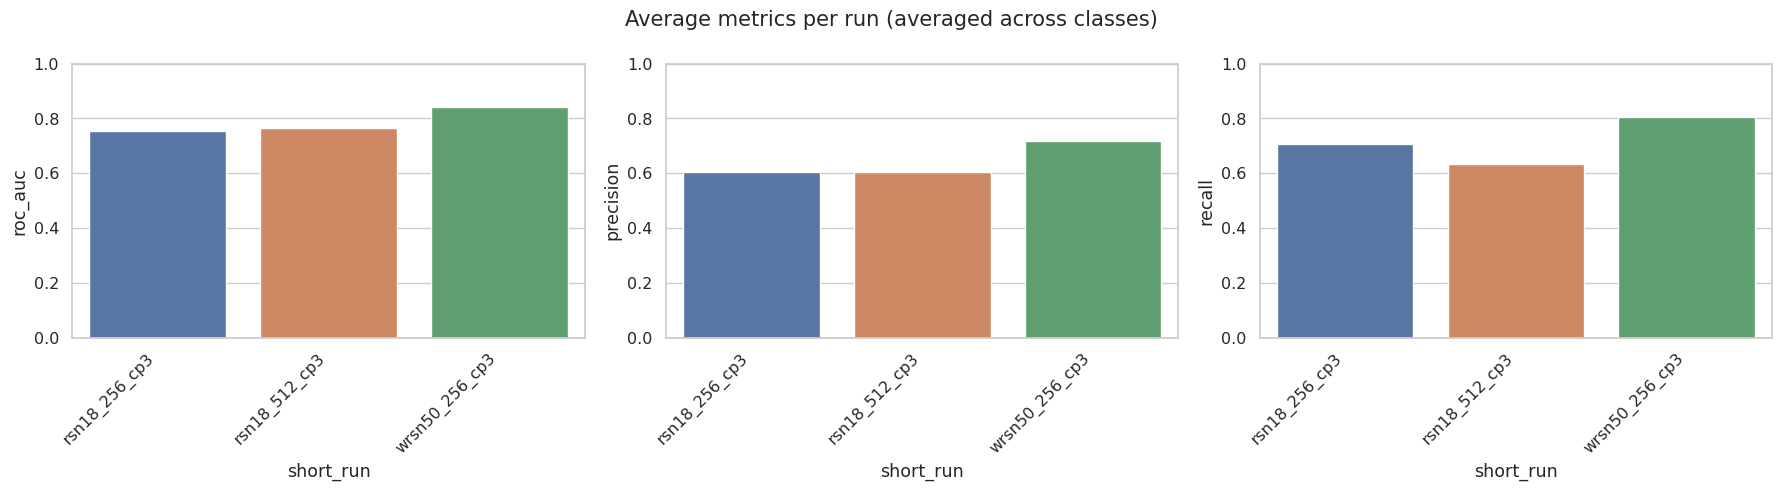

In [29]:
# Quick comparison plot for top-level metrics from master_results.csv
# We'll compare ROC AUC, Precision, Recall, F1 across runs (aggregated across classes)
if master_all.empty:
    print('No master results available to plot. Check run_names and results_root.')
else:
    # Use short run names for plotting
    master_all['short_run'] = master_all['run_name'].map(run_name_map)

    # Plot ROC AUC per class across runs (heatmap + bar)
    plt.figure(figsize=(10, 6))
    sns.barplot(data=master_all, x='class_name', y='roc_auc', hue='short_run')
    plt.title('ROC AUC by class and run')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Heatmap of runs x classes for ROC AUC
    pivot = master_all.pivot_table(index='class_name', columns='short_run', values='roc_auc')
    plt.figure(figsize=(max(6, pivot.shape[1]*1.6), max(4, pivot.shape[0]*0.5+2)))
    sns.heatmap(pivot, annot=True, fmt='.3f', cmap='viridis')
    plt.title('ROC AUC heatmap (class x run)')
    plt.xlabel('Run')
    plt.ylabel('Class')
    plt.tight_layout()
    plt.show()

    # Run-level summary plots
    run_summary = master_all.groupby('short_run').agg({'roc_auc': 'mean', 'precision': 'mean', 'recall': 'mean', 'f1_score': 'mean'}).reset_index()
    display(run_summary)
    fig, ax = plt.subplots(1, 3, figsize=(18, 5))
    for a in ax:
        a.set_ylim(0, 1)
    sns.barplot(data=run_summary, x='short_run', y='roc_auc', ax=ax[0], hue='short_run')
    sns.barplot(data=run_summary, x='short_run', y='precision', ax=ax[1], hue='short_run')
    sns.barplot(data=run_summary, x='short_run', y='recall', ax=ax[2], hue='short_run')
    for a in ax:
        a.set_xticklabels(a.get_xticklabels(), rotation=45, ha='right')
    plt.suptitle('Average metrics per run (averaged across classes)')
    plt.tight_layout()
    plt.show()

In [30]:
# Compare a single class across runs. Edit `class_to_compare` to choose the class folder name.
class_to_compare = 'color_profile_1'  # e.g. 'color_profile_1' or set to None to list available classes
if class_reports_all.empty:
    print('No class-level reports loaded.')
else:
    if class_to_compare is None:
        print('Available classes:')
        print(sorted(class_reports_all['class_folder'].unique()))
    else:
        subset = class_reports_all[class_reports_all['class_folder'] == class_to_compare]
        if subset.empty:
            print(f'Class {class_to_compare} not found in class reports')
        else:
            display(subset[['run_name', 'class_folder', 'roc_auc', 'pr_auc', 'cohen_d', 'wasserstein']])
            plt.figure(figsize=(8, 5))
            x = 'run_name'
            sns.barplot(data=subset, x=x, y='roc_auc')
            plt.title(f'ROC AUC for class {class_to_compare} across runs')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

Class color_profile_1 not found in class reports


No class chosen; defaulting to first discovered class: color_profile_3
Loaded per-image rows: 345


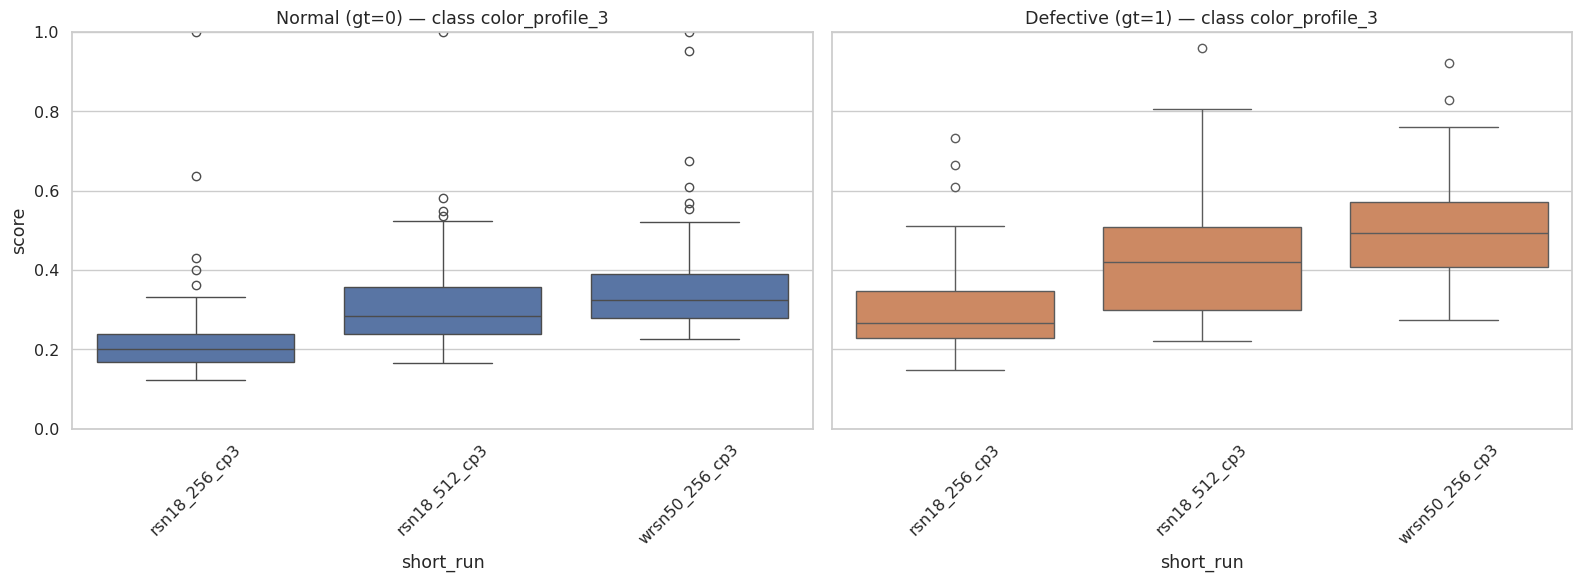

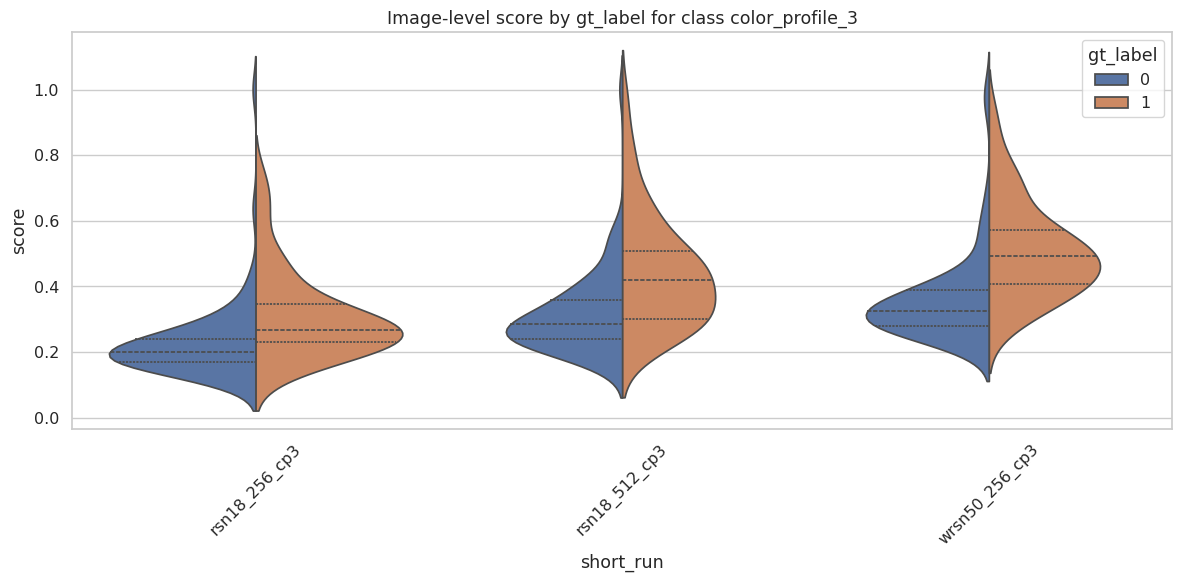

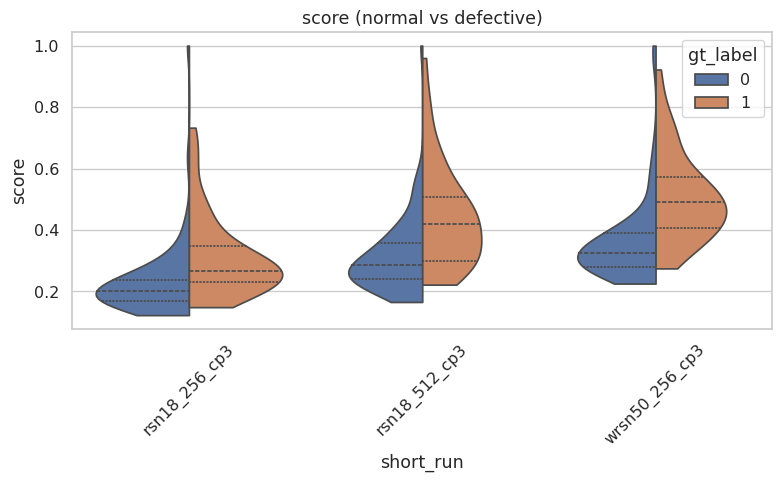

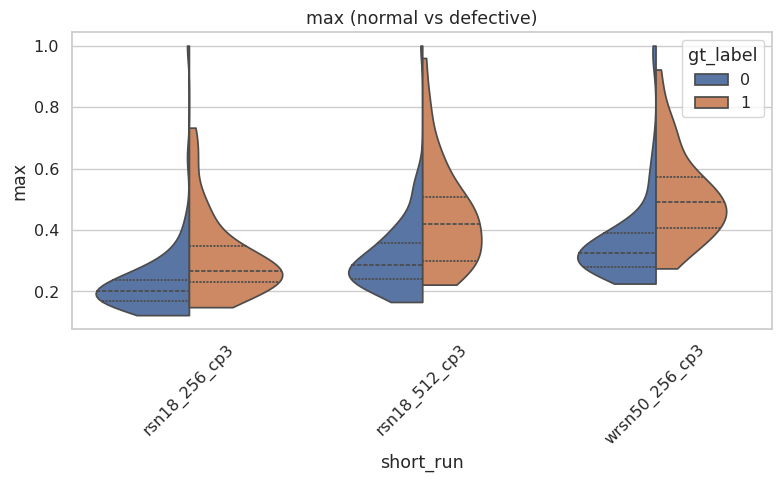

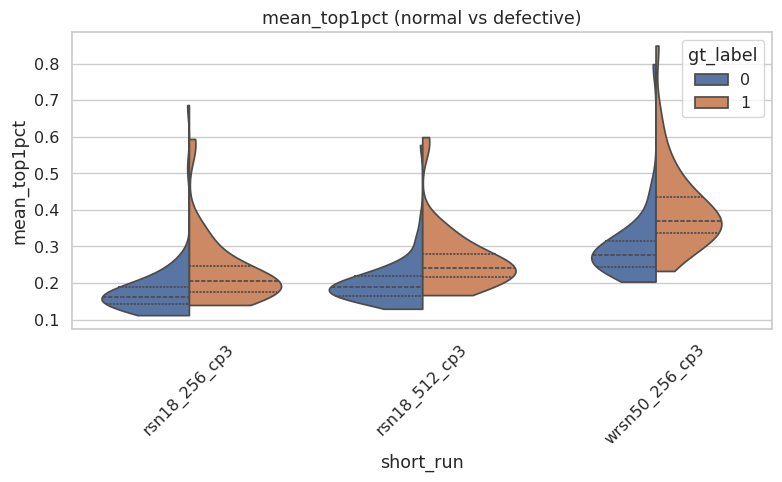

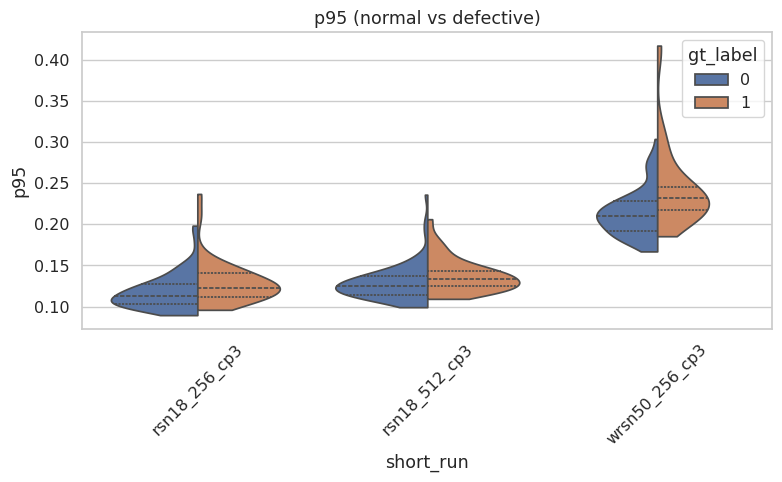

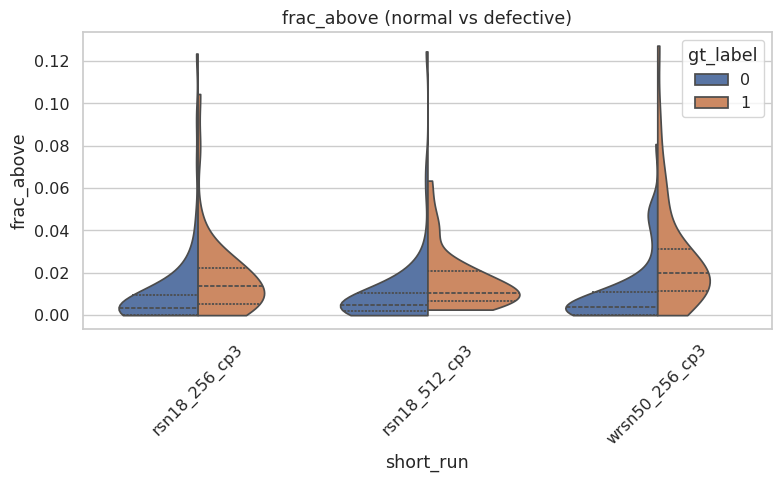

In [31]:
# Image-level comparison visualizations (per-image distributions and per-image comparisons)
# Choose a class to visualize image-level metrics across runs. If None, pick the first available.
class_for_images = None
if class_for_images is None:
    if not class_reports_all.empty:
        class_for_images = class_reports_all['class_folder'].unique()[0]
        print(f'No class chosen; defaulting to first discovered class: {class_for_images}')
    else:
        print('No class reports found in runs; unable to perform image-level plots.')

if class_for_images:
    dfs = []
    for rn in run_names:
        per_image_path = results_root / rn / class_for_images / 'per_image_metrics.csv'
        if not per_image_path.exists():
            warnings.warn(f'No per_image_metrics.csv for run {rn}, class {class_for_images}')
            continue
        try:
            d = pd.read_csv(per_image_path)
            d['run_name'] = rn
            d['short_run'] = shorten_run_name(rn)
            dfs.append(d)
        except Exception as e:
            warnings.warn(f'Failed reading {per_image_path}: {e}')
    if len(dfs) == 0:
        print('No per-image data loaded for that class across the selected runs')
    else:
        all_images = pd.concat(dfs, ignore_index=True)
        print('Loaded per-image rows:', len(all_images))

        # Prepare subsets by ground-truth label (0 = normal, 1 = defective)
        if 'gt_label' in all_images.columns:
            normal = all_images[all_images['gt_label'] == 0].copy()
            defective = all_images[all_images['gt_label'] == 1].copy()
        else:
            # if no gt_label present, treat everything as 'normal' and keep defective empty
            normal = all_images.copy()
            defective = pd.DataFrame(columns=all_images.columns)

        # 1) Image-level score boxplots side-by-side (normal vs defective)
        fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
        sns.boxplot(data=normal, x='short_run', y='score', ax=axes[0])
        axes[0].set_title(f'Normal (gt=0) — class {class_for_images}')
        axes[0].tick_params(axis='x', rotation=45)
        axes[0].set_ylim(0, 1)
        sns.boxplot(data=defective, x='short_run', y='score', ax=axes[1], color='C1')
        axes[1].set_title(f'Defective (gt=1) — class {class_for_images}')
        axes[1].tick_params(axis='x', rotation=45)
        axes[1].set_ylim(0, 1)
        plt.tight_layout()
        plt.show()

        # Keep the existing violin-with-hue plot unchanged (it already separates gt_label visually)
        if 'gt_label' in all_images.columns:
            plt.figure(figsize=(12, 6))
            sns.violinplot(data=all_images, x='short_run', y='score', hue='gt_label', split=True, inner='quartile')
            plt.title(f'Image-level score by gt_label for class {class_for_images}')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

        # 4) Multi-metric dual-violin plots: make each metric its own figure and show gt_label as split violins
        metrics = [m for m in ['score','max','mean_top1pct','p95','frac_above'] if m in all_images.columns]
        if metrics:
            for metric in metrics:
                plt.figure(figsize=(8, 5))
                if 'gt_label' in all_images.columns:
                    try:
                        sns.violinplot(data=all_images, x='short_run', y=metric, hue='gt_label', split=True, inner='quartile', cut=0)
                    except Exception:
                        # fallback to non-split (side-by-side) if split isn't supported
                        sns.violinplot(data=all_images, x='short_run', y=metric, hue='gt_label', inner='quartile', cut=0)
                    plt.title(f'{metric} (normal vs defective)')
                else:
                    sns.violinplot(data=all_images, x='short_run', y=metric, inner='quartile', cut=0)
                    plt.title(f'{metric}')
                plt.xticks(rotation=45)
                plt.tight_layout()
                plt.show()
else:
    print('No class_for_images set and no classes discovered.')

,run_a,run_b,stat,p_value
0,rsn18_256_cp3,rsn18_512_cp3,3180.5,1.039166e-11
1,rsn18_256_cp3,wrsn50_256_cp3,1934.5,1.853667e-20
2,rsn18_512_cp3,wrsn50_256_cp3,4902.5,7.037903e-04


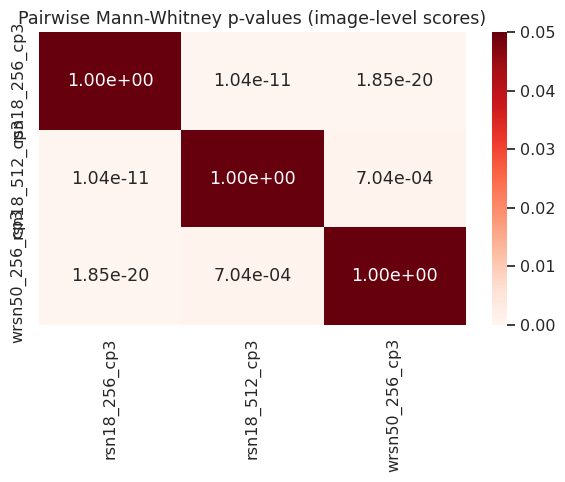

In [32]:
# Image-level statistical comparisons and p-value heatmap
from itertools import combinations

if 'all_images' not in globals():
    print('Run the image-loading cell first (the per-image visualizations cell).')
else:
    grouped = all_images.groupby('short_run')
    runs = list(grouped.groups.keys())
    if len(runs) < 2:
        print('Need at least two runs with per-image data to compute pairwise tests.')
    else:
        results = []
        for a, b in combinations(runs, 2):
            a_vals = grouped.get_group(a)['score'].dropna().values
            b_vals = grouped.get_group(b)['score'].dropna().values
            if len(a_vals) == 0 or len(b_vals) == 0:
                continue
            try:
                stat, p = sps.mannwhitneyu(a_vals, b_vals, alternative='two-sided')
            except Exception as e:
                warnings.warn(f'Failed test for {a} vs {b}: {e}')
                continue
            results.append({'run_a': a, 'run_b': b, 'stat': float(stat), 'p_value': float(p)})
        if len(results) == 0:
            print('No pairwise test results')
        else:
            resdf = pd.DataFrame(results)
            display(resdf)
            # Create p-value matrix heatmap
            pv = pd.DataFrame(np.ones((len(runs), len(runs))), index=runs, columns=runs)
            for row in results:
                pv.loc[row['run_a'], row['run_b']] = row['p_value']
                pv.loc[row['run_b'], row['run_a']] = row['p_value']
            plt.figure(figsize=(6,5))
            sns.heatmap(pv, annot=True, fmt='.2e', cmap='Reds', vmin=0, vmax=0.05)
            plt.title('Pairwise Mann-Whitney p-values (image-level scores)')
            plt.tight_layout()
            plt.show()